In [1]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from options import *
from constants import *

mpl.rcParams.update(rcParams)

In [2]:
p = plt.rcParams
p['axes.grid'] = False
p['xtick.bottom'] = False
p['xtick.labelbottom'] = False
p['ytick.left'] = False
p['ytick.labelleft'] = False

p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0
p['figure.subplot.right']  = 1
p['figure.subplot.top']    = 1
p['figure.subplot.bottom'] = 0

In [3]:
run_processing = True
acquisitions = [1,2,12]

Rendering acquisition 1 image
Image saved
Rendering acquisition 2 image
Image saved
Rendering acquisition 12 image
Image saved


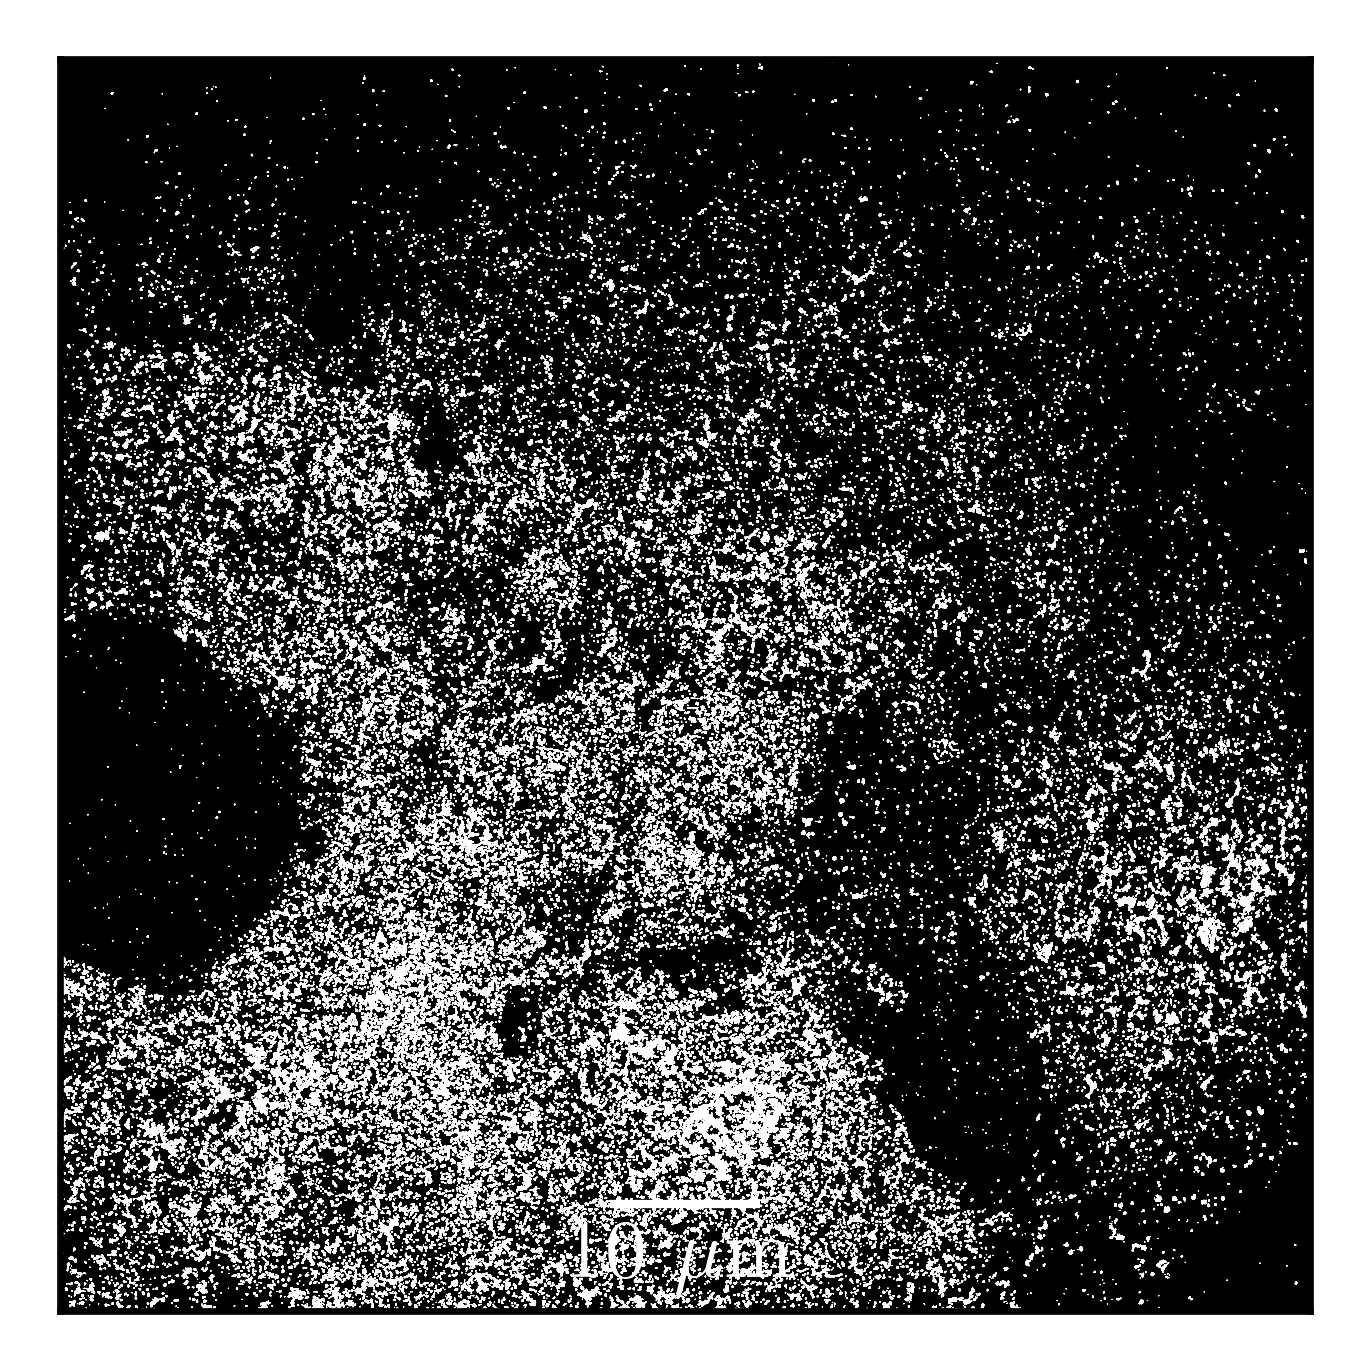

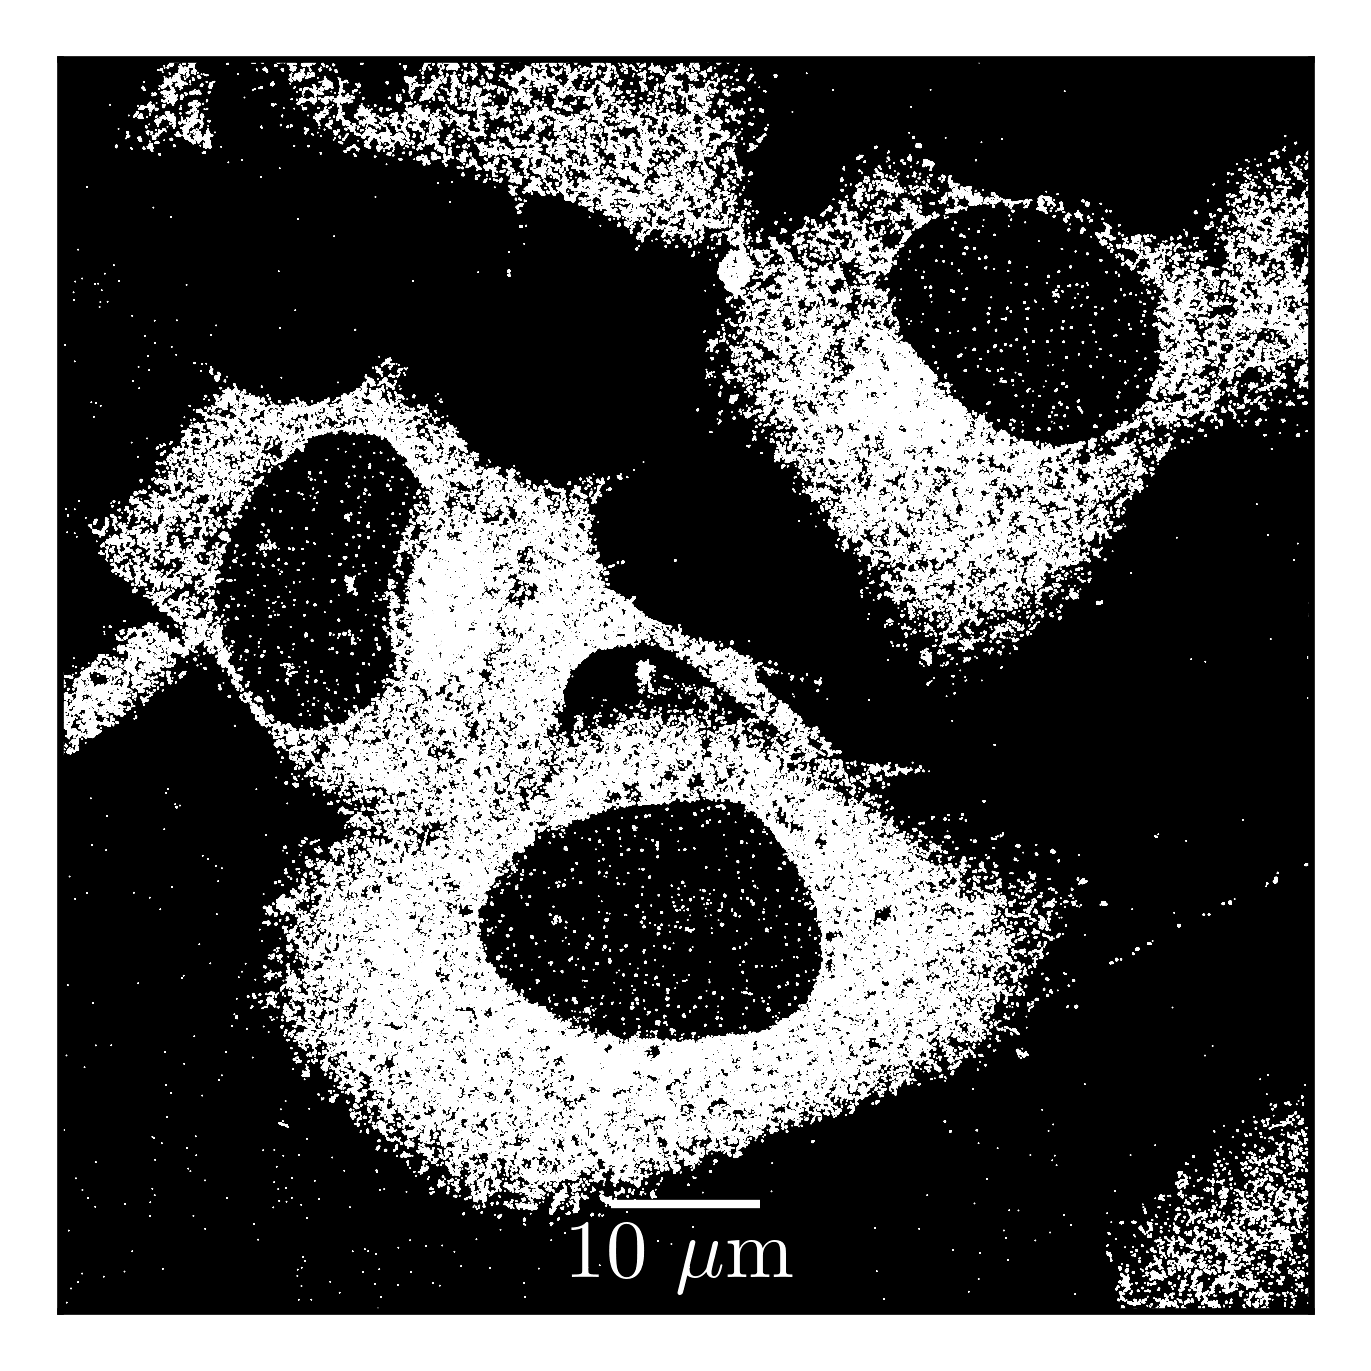

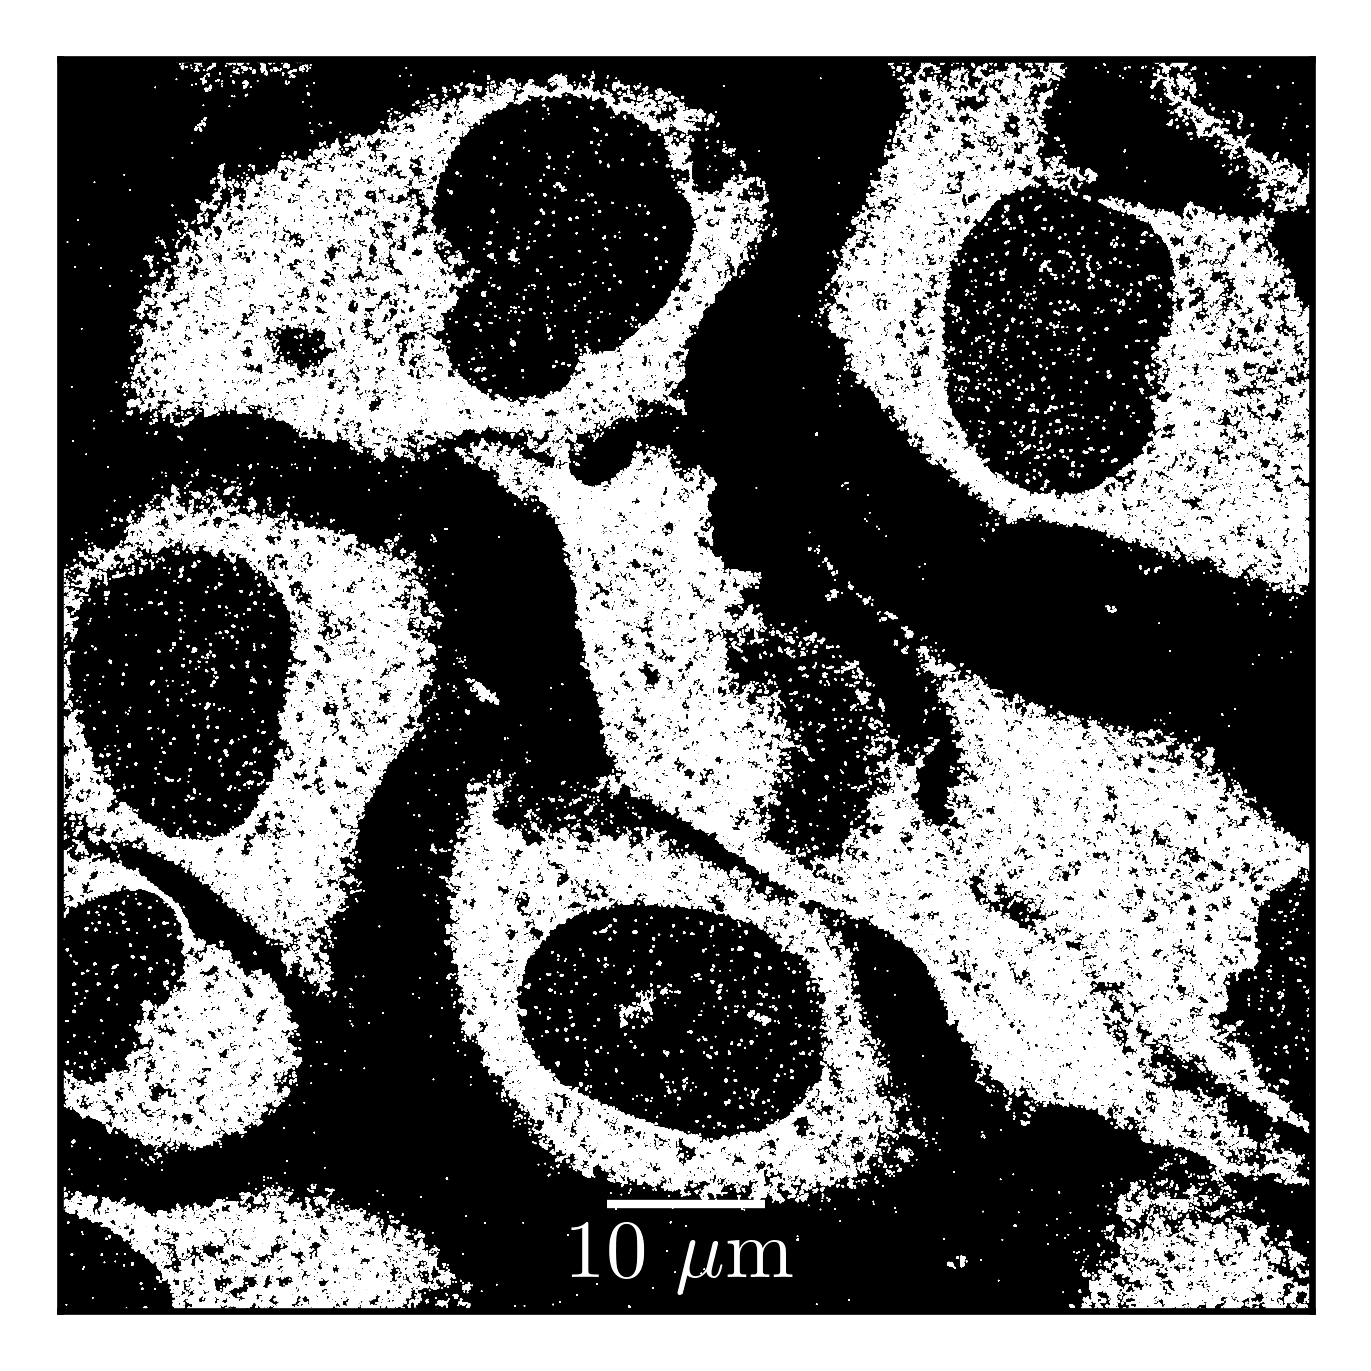

In [5]:
# The result of the Gaussian rendering visualisation can be plotted.
for i in acquisitions:
    print(f"Rendering acquisition {i} image")
    histogram = np.load(f"../data/imaging/clathrin_image{i}.npy")
    plt.figure(figsize=(5.3*INCH_PER_CM,5.3*INCH_PER_CM), dpi=600)
    ax = plt.gca()
    plt.imshow(histogram.T, vmax=15, cmap='Greys_r');

    scalebar = AnchoredSizeBar(ax.transData,
                                size=10000/5, label=r'10 $\mu$m', loc='lower center', # for size: divide by 5 the desired length in nm
                                pad=0.1, color='white',
                                frameon=False, size_vertical=1,
                                fontproperties={"size": 10, "family" : "sans-serif"})
    ax.add_artist(scalebar)
    plt.savefig(f"../figures/clathrin_image{i}.png")
    print("Image saved")

In [4]:
if (run_processing):
    # histograms = []
    print("Starting clathrin imaging")
    for i in acquisitions:
        print(f"Starting acquisition {i} processing")
        # id,frame,x [nm],y [nm],sigma [nm],intensity [photon],amplitude [photon],offset [photon],bkgstd [photon],uncertainty_xy [nm]
        id, frame, x, y, sigma, intensity, amplitude, offset, bkgstd, uncertainty_xy = np.loadtxt(f"../data/clathrin/Acquisition-{i}/CoordTable_SAFE180_2D.csv", unpack=True, delimiter=',', skiprows=1)
        print(f"Localisation data loaded from ../data/clathrin/Acquisition-{i}/CoordTable_SAFE180_2D.csv")
        pixel_recon_dim = 5

        # We find the minimum X and Y values in our dataset. They will be used to shift
        # all data points to the left or up.
        min_x = np.floor(np.min(x))
        min_y = np.floor(np.min(y))
        x -= min_x
        y -= min_y

        # We determine the maximum X and Y coordinates to generate proper histograms.
        min_x = 0
        min_y = 0
        max_x = np.ceil(np.max(x))
        max_y = np.ceil(np.max(y))

        # First, we create an empty image that we will populate with emitters
        hist_Gaussian = np.zeros((int(max_x/pixel_recon_dim)+3, int(max_y/pixel_recon_dim)+3))

        # Next, we loop over all emitters and increase the image pixels based on the Gaussian profile
        print("Starting Gaussian profiling")
        for j, boh in enumerate(x):
            #First we re-scale the position based on pixel size
            emitter_info = [x[j]/pixel_recon_dim, y[j]/pixel_recon_dim]
            # Since our data input does not contain emitter-specific localization error information, we have a global value.
            # However, this could reasonably be changed to emitter-specific errors.
            emitter_locerror = 10/pixel_recon_dim #10 nm, rescaled on pixel size
            # We will populate this rendered Gaussian for 3 std each direction, accounting
            # for > 99.7pct of all emitter data. We take size of image into account
            std_gaussian = emitter_locerror
            start_xpos = np.max([round(emitter_info[0]-3*std_gaussian),0])
            end_xpos = np.min([round(emitter_info[0]+3*std_gaussian),np.shape(hist_Gaussian)[0]])
            start_ypos = np.max([round(emitter_info[1]-3*std_gaussian),0])
            end_ypos = np.min([round(emitter_info[1]+3*std_gaussian),np.shape(hist_Gaussian)[1]])

            # Now we loop over these found pixels and increase the value in these pixels
            # based on the gaussian profile and emitter intensity
            for xx in range(start_xpos,end_xpos):
                for yy in range(start_ypos,end_ypos):
                    hist_Gaussian[xx,yy] += intensity[i]*np.exp(-((xx-emitter_info[0])**2/(2*std_gaussian**2)+(yy-emitter_info[1])**2/(2*std_gaussian**2)))
        # histograms.append(hist_Gaussian)
        print(f"Acquisition {i} processing complete")
        np.save(f"../data/imaging/clathrin_image{i}", hist_Gaussian)
        print(f"Data saved in ../data/imaging/clathrin_image{i}")


Starting clathrin imaging
Starting acquisition 1 processing
Localisation data loaded from ../data/clathrin/Acquisition-1/CoordTable_SAFE180_2D.csv
Starting Gaussian profiling
Acquisition 1 processing complete
Data saved in ../data/imaging/clathrin_image1
Starting acquisition 2 processing
Localisation data loaded from ../data/clathrin/Acquisition-2/CoordTable_SAFE180_2D.csv
Starting Gaussian profiling
Acquisition 2 processing complete
Data saved in ../data/imaging/clathrin_image2
Starting acquisition 12 processing
Localisation data loaded from ../data/clathrin/Acquisition-12/CoordTable_SAFE180_2D.csv
Starting Gaussian profiling
Acquisition 12 processing complete
Data saved in ../data/imaging/clathrin_image12
